In [1]:
# !git clone https://github.com/iamatulsingh/pinterest-image-scrap.git

In [2]:
# !pip install pydotmap

In [3]:
# !python3 /content/pinterest-image-scrap/pinterest.py

In [1]:
!pip install mtcnn

In [2]:
# function for face detection with mtcnn
from PIL import Image
from numpy import asarray
from mtcnn.mtcnn import MTCNN
import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from os import listdir
from tensorflow import keras

In [3]:
model = keras.models.load_model('/content/drive/MyDrive/facenet_keras.h5')

In [4]:
model.summary()

Model: "inception_resnet_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv2d_1a_3x3 (Conv2D)          (None, 79, 79, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
Conv2d_1a_3x3_BatchNorm (BatchN (None, 79, 79, 32)   96          Conv2d_1a_3x3[0][0]              
__________________________________________________________________________________________________
Conv2d_1a_3x3_Activation (Activ (None, 79, 79, 32)   0           Conv2d_1a_3x3_BatchNorm[0][0]    
________________________________________________________________________________

In [5]:
# create the detector, using default weights
detector = MTCNN()

In [6]:
# extract a single face from a given photograph
def extract_face(filename, required_size=(160, 160)):
	# load image from file
	image = Image.open(filename)
	# convert to RGB, if needed
	image = image.convert('RGB')
	# convert to array
	pixels = asarray(image)
	# detect faces in the image
	results = detector.detect_faces(pixels)
	# extract the bounding box from the first face
	x1, y1, width, height = results[0]['box']
	# bug fix
	x1, y1 = abs(x1), abs(y1)
	x2, y2 = x1 + width, y1 + height
	# extract the face
	face = pixels[y1:y2, x1:x2]
	# resize pixels to the model size
	image = Image.fromarray(face)
	image = image.resize(required_size)
	face_array = asarray(image)
	return face_array

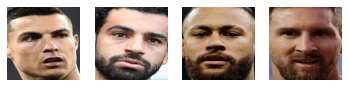

In [7]:
directory = '/content/drive/MyDrive/database/'
test_directory = '/content/drive/MyDrive/test/'

i = 1
# enumerate files
for filename in listdir(directory):
	# path
	path = directory + filename
	# get face
	face = extract_face(path)
	# plot
	plt.subplot(1,4, i)
	plt.axis('off')
	plt.imshow(face)
	i += 1
plt.show()

In [8]:
# load images and extract faces for all images in a directory
def load_faces(directory):
	faces = list()
	# enumerate files
	for filename in listdir(directory):
		# path
		path = directory + filename
		# get face
		face = extract_face(path)
		# store
		faces.append(face)
	return faces

In [9]:
# load a database that contains one subdir for each class that in turn contains images
X, y = list(), list()
# load all faces in the subdirectory
faces = load_faces(directory)
# create labels
labels = listdir(directory)
# store
X.extend(faces)
y.extend(labels)

X , y = asarray(X), asarray(y)

In [10]:
# load a testset
X_test = list()
# load all faces in the subdirectory
faces_test = load_faces(test_directory)
# store
X_test.extend(faces_test)
X_test = asarray(X_test)

In [11]:
X = X.astype('float')
mean, std = X.mean(), X.std()
X = (X - mean)/std

In [12]:
X_tests = X_test.astype('float')
mean, std = X_tests.mean(), X_tests.std()
X_tests = (X_tests - mean)/std

In [13]:
embeds = model(X)

In [14]:
embeds.shape

TensorShape([4, 128])

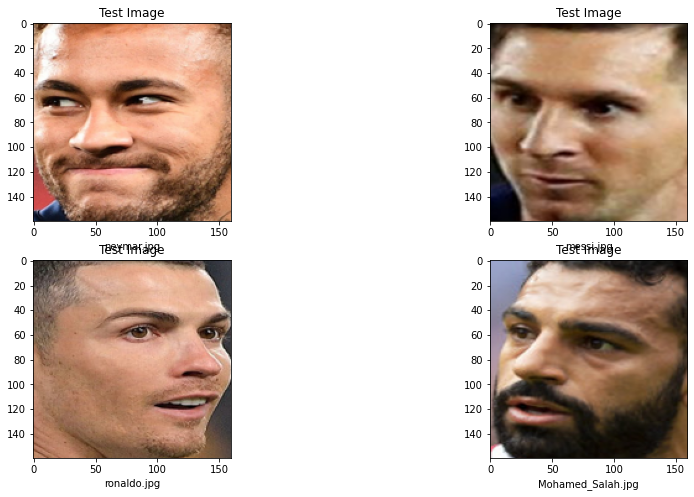

In [15]:
# plot test image with predicted label
fig, axs = plt.subplots(2,2, figsize=(15, 8))
for i, ax in enumerate(axs.flat):

  embed_test = model(np.expand_dims(X_tests[i],axis=0))

  diff = tf.reduce_sum(tf.subtract(embeds,embed_test)**2,axis=1)

  label_index = tf.argmin(diff)

  ax.imshow(X_test[i])
  ax.set_xlabel(labels[label_index])
  ax.set_title('Test Image')
